# Ensemble: siconc

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'SImon'
experiment = 'ssp585'
variable_id = 'siconc'

spatial_text = 'sea-ice concentration'
spatial_units = '%'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Area ({time_series_units})'
time_series_y_range = (0, 1.2e7)
time_series_y_range_full = (0, 1.2e7)
time_series_y_range_monthly = (0, 1.2e7)
time_series_y_range_regional = (0, 3.5e6)

# Convert from m2 to km2 and % to fraction
time_series_process = conf['weighting_process']

colormesh_kwargs = {
    'extend': 'neither',
    'levels': 11,
    #'shading': 'auto', # NB change to 'gouraud' if Jaspy
    'vmin': 15,
    'vmax': 100,
    'x': 'longitude', 
    'y': 'latitude'
}

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id
)

ensemble_time_series = libs.local.get_ensemble_series(variable_id, experiment)
ensemble_time_series_smooth = libs.local.get_ensemble_series(variable_id, experiment, suffix='_smooth')

time_slices = libs.vars.default_time_slices()
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

obs_arr = []
for obs in conf['obs']:
    obs_data = libs.local.get_obs(**obs) * 100

    obs_arr.append({
        'color': obs_data.attrs['color'],
        'data': obs_data,
        'label': obs_data.attrs['label']
    })
    
obs_ts, obs_ts_smooth = libs.ensemble.time_series_weighted(
    obs_arr,
    weight,
    weighting_method=conf['weighting_method'],
    weighting_process=conf['weighting_process']
)

## Time series

### Mean

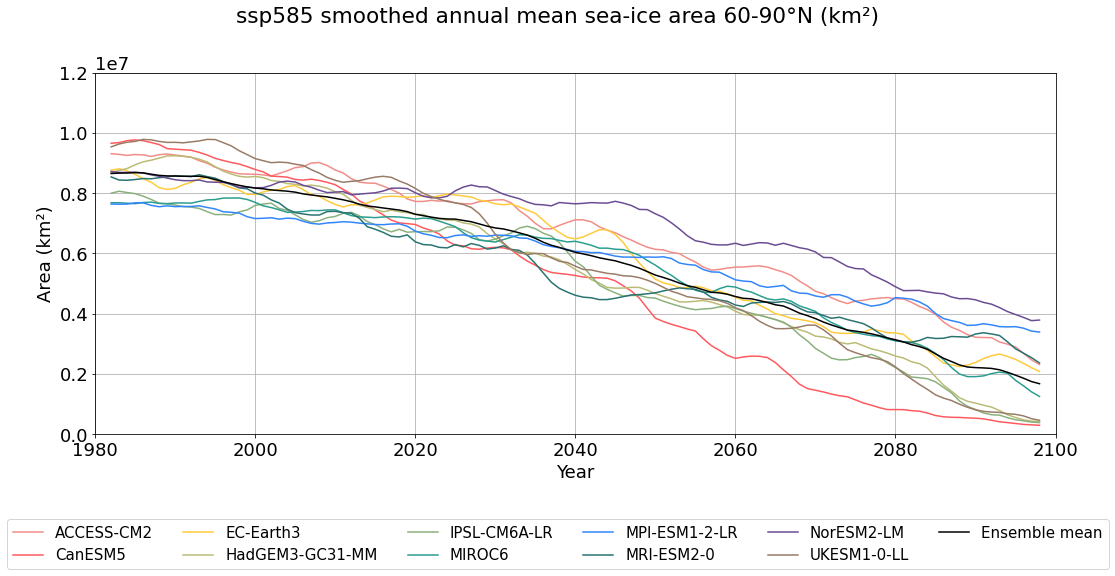

In [4]:
vars_series = [
    ensemble_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)


libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} smoothed annual mean {time_series_text} 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);

### September (min) & March (max)

In [5]:
ensemble_time_series_tas = time_series_process(
    libs.local.get_ensemble_series('tas', experiment)
)

tas_processed = ensemble_time_series_tas.groupby('time.year').mean('time').rolling(year=5, center=True).mean('year')
tas_processed = libs.ensemble.calc_variable_mean(tas_processed)

tas_years = {}
for key in tas_processed:
    years = tas_processed[key].where(tas_processed[key] > 0, drop=True).year.values
    if len(years) > 0:
        tas_years[key] = years[0]

In [6]:
data_vars_mar = {}
data_vars_sep = {}

for i, item in enumerate(ensemble):
    processed_data = time_series_process(item['data'])
    processed_data.attrs['color'] = item['color']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    
    item_weighted_mar = processed_data.where(processed_data.time['time.month'] == 3, drop=True).weighted(weight)
    item_reduced_mar = getattr(
        item_weighted_mar, 
        time_series_weighted_method
    )(dim=item_weighted_mar.weights.dims, skipna=True)
    
    item_weighted_sep = processed_data.where(processed_data.time['time.month'] == 9, drop=True).weighted(weight)
    item_reduced_sep = getattr(
        item_weighted_sep, 
        time_series_weighted_method
    )(dim=item_weighted_sep.weights.dims, skipna=True)
    item_reduced_sep.attrs['plot_kwargs'] = { 'linestyle': (0, (5, 1)) }
    
    # Groupby + mean to resample from monthly time to year
    data_vars_mar[item['label']] = item_reduced_mar.groupby('time.year').mean('time')
    data_vars_sep[item['label']] = item_reduced_sep.groupby('time.year').mean('time')

ds_mar = xarray.Dataset(data_vars=data_vars_mar)
ds_mar = libs.ensemble.calc_variable_mean(ds_mar)

ds_sep = xarray.Dataset(data_vars=data_vars_sep)
ds_sep = libs.ensemble.calc_variable_mean(ds_sep)
ds_sep['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': (0, (5, 1)) }

for i, item in enumerate(obs_arr):
    processed_data = time_series_process(item['data'])
    processed_data.attrs['color'] = item['color']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    
    item_weighted_mar = processed_data.where(processed_data.time['time.month'] == 3, drop=True).weighted(weight)
    item_reduced_mar = getattr(
        item_weighted_mar, 
        time_series_weighted_method
    )(dim=item_weighted_mar.weights.dims, skipna=True)
    item_reduced_mar.attrs['plot_kwargs'] = { 'linestyle': 'solid', 'linewidth': 3 }
    
    item_weighted_sep = processed_data.where(processed_data.time['time.month'] == 9, drop=True).weighted(weight)
    item_reduced_sep = getattr(
        item_weighted_sep, 
        time_series_weighted_method
    )(dim=item_weighted_sep.weights.dims, skipna=True)
    item_reduced_sep.attrs['plot_kwargs'] = { 'linestyle': (0, (5, 1)), 'linewidth': 3 }
    
    # Groupby + mean to resample from monthly time to year, then add to ensemble datasets
    ds_mar[item['label']] = item_reduced_mar.groupby('time.year').mean('time')
    ds_sep[item['label']] = item_reduced_sep.groupby('time.year').mean('time')

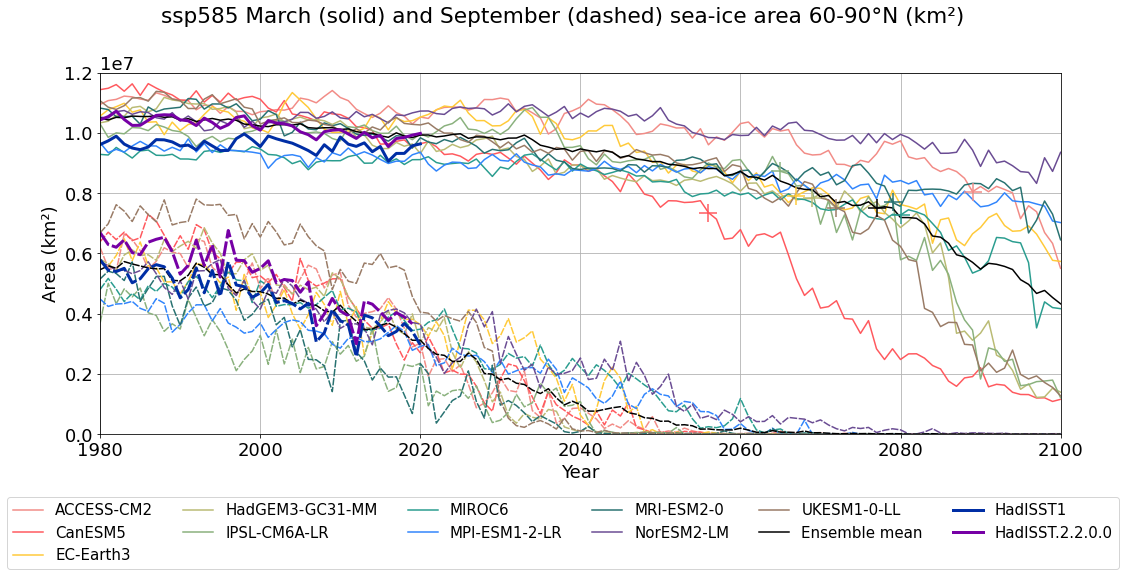

In [7]:
fig = libs.plot.time_series_from_vars(
    [
        ds_mar, 
        ds_sep
    ],
    title=f'{experiment} March (solid) and September (dashed) {time_series_text} 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);

for key in tas_years:
    color = ds_mar[key].attrs['color']
    y = float(ds_mar[key].sel({ 'year': tas_years[key] }).values)
    fig.axes[0].scatter(tas_years[key], y, 300, color=color, marker='+', zorder=10)

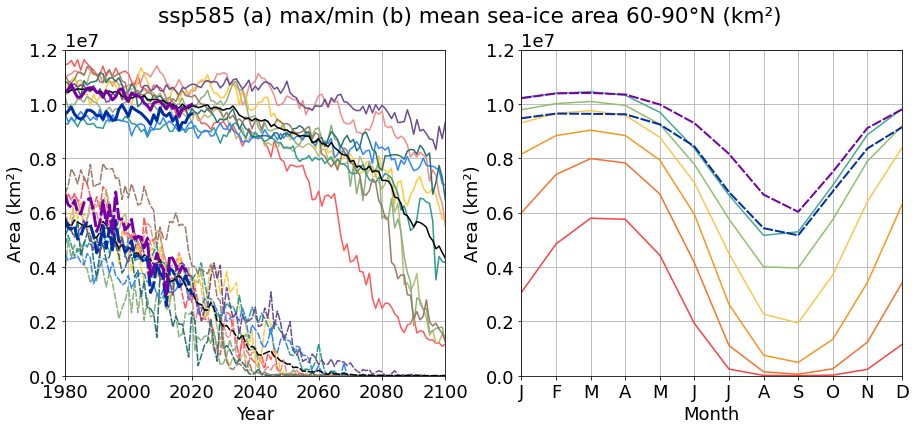

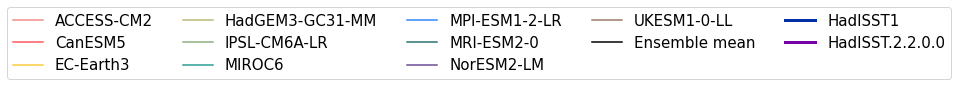

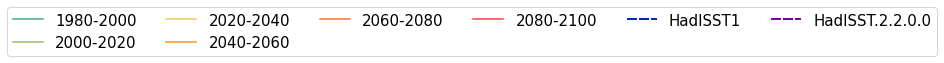

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
fig.suptitle(f'{experiment} (a) max/min (b) mean {time_series_text} 60-90°N ({time_series_units})')

vars_series = [
    ensemble_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)

libs.plot.time_series_from_vars(
    [
        ds_mar, 
        ds_sep
    ],
    ax=axes[0],
    fig=fig,
    show_legend=False,
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);

arr = []
for s in libs.vars.time_slices_20y():
    s_label = s['label']
    data_slice = ensemble_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    data_slice['Ensemble mean'].attrs['color'] = s['color']
    data_slice['Ensemble mean'].attrs['label'] = s['label']
    arr.append(data_slice)


obs_compare_slice = libs.vars.time_slices_20y()[0]['slice']
for obs_item in obs_ts:
    # Not ensemble mean, but using name for ease in monthly variability plot
    obs_ts_slice = xarray.Dataset(
        data_vars={ 
            'Ensemble mean': obs_item['data'].sel(**obs_compare_slice).groupby('time.month').mean('time')
        }
    )
    arr.append(obs_ts_slice)


libs.plot.monthly_variability(
    arr,
    ax=axes[1],
    fig=fig,
    legend_below=True,
    show_legend=False,
    variables=['Ensemble mean'],
    ylabel=time_series_y_label,
    yrange=(0, 1.2e7)
)

libs.plot.legend_standalone(
    fig,
    legend_confs=[
        { 'ncol': 5, 'exclude': [] },
        { 'ncol': 6, 'exclude': arr[-1].keys() },
    ]
)

### September (min) & March (max) - Regional

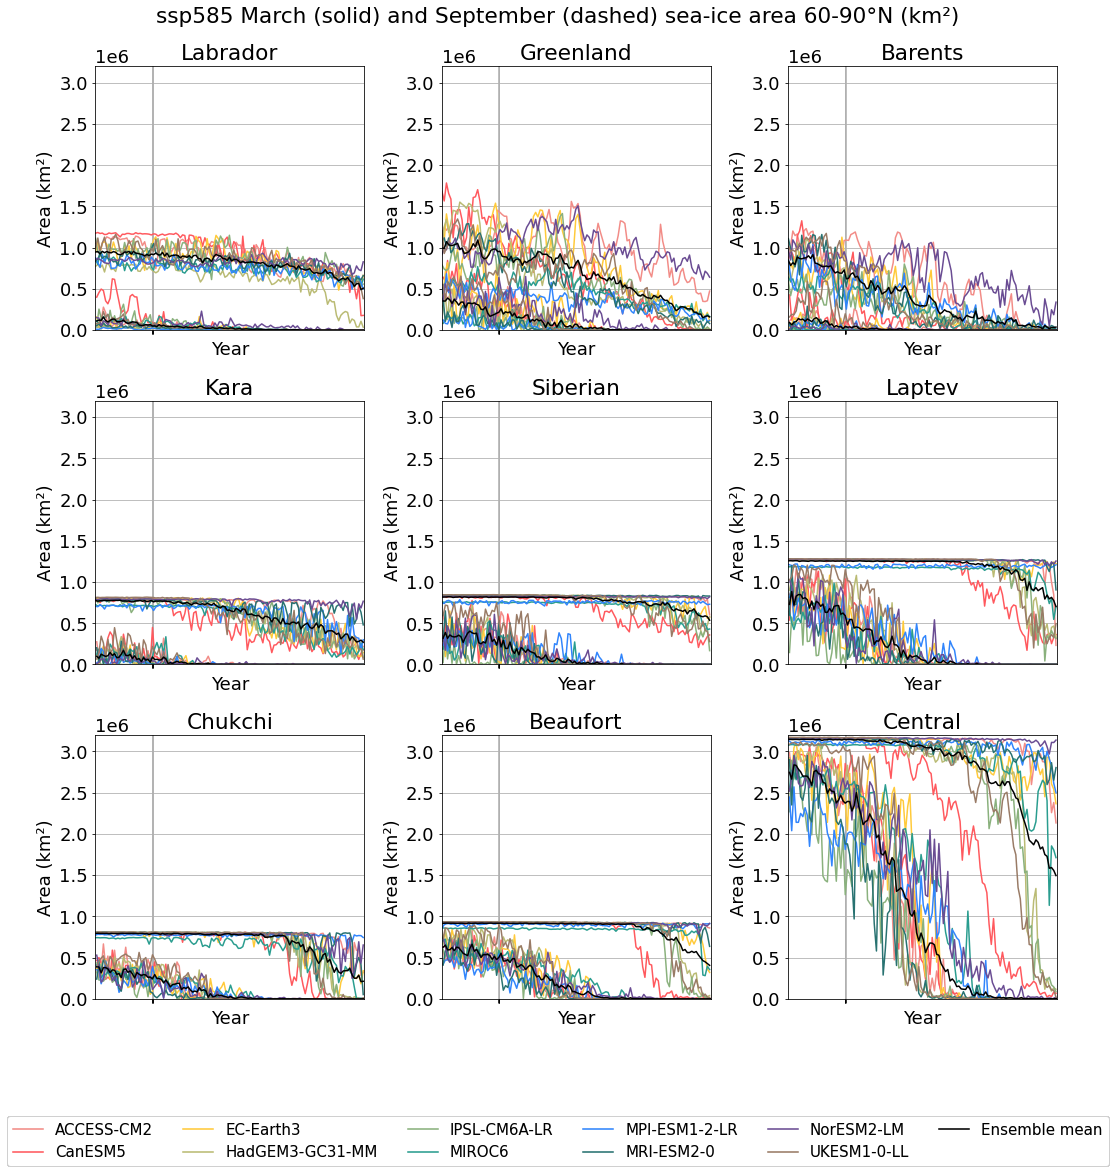

In [9]:
regions = libs.local.get_ensemble_regional_series(variable_id, experiment)

fig, axes = plt.subplots(*(3, 3), figsize=(15, 15))
axes = axes.flatten()
fig.suptitle(
    f'{experiment} March (solid) and September (dashed) {time_series_text} 60-90°N ({time_series_units})'
)

for i, data_siconc in enumerate(regions):
    region = data_siconc.attrs['region']
    
    data_mar = data_siconc.where(data_siconc.time['time.month'] == 3, drop=True)
        #.groupby('time.year').mean('time', skipna=True)
    #data_mar = libs.ensemble.calc_variable_mean(data_mar, 'time')
    data_sep = data_siconc.where(data_siconc.time['time.month'] == 9, drop=True)
        #.groupby('time.year').mean('time', skipna=True)
    #data_sep = libs.ensemble.calc_variable_mean(data_sep, 'time')
    data_sep.attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
        
    fig = libs.plot.time_series_from_vars(
        [
            data_mar,
            data_sep
        ],
        ax=axes[i],
        fig=fig,
        xattr='time',
        ylabel=time_series_y_label,
        yrange=(0, 3.2e6)
    )
    
    axes[i].set_title(region)
    axes[i].set_xticks([1980, 2020, 2060, 2100])

### Full variability

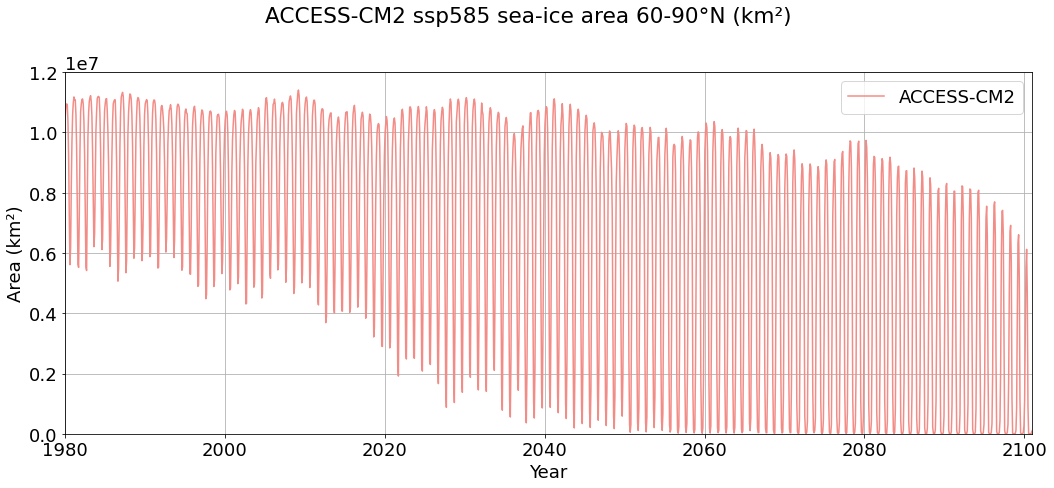

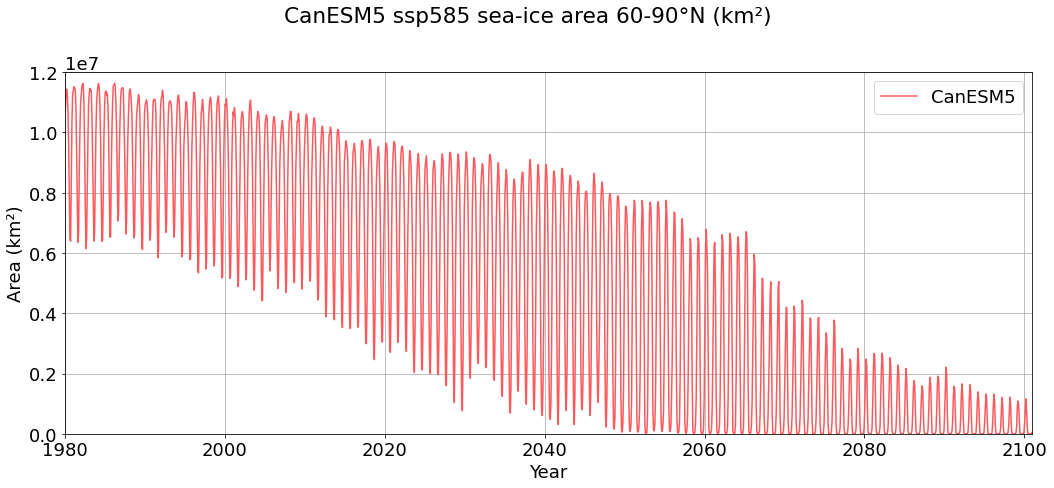

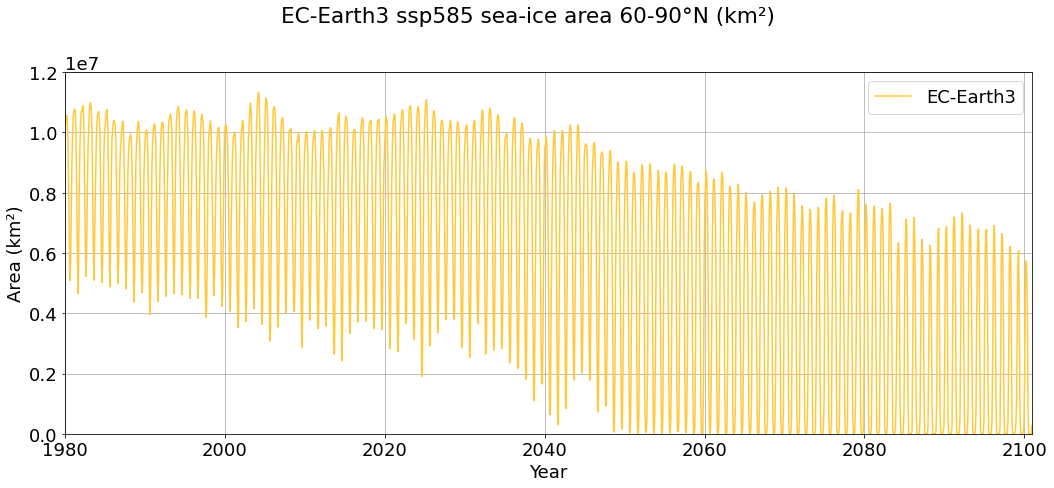

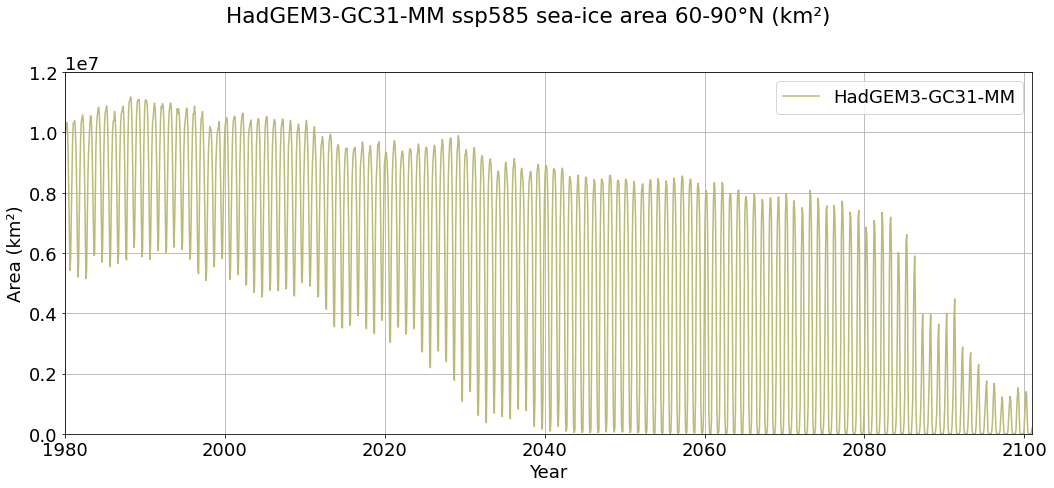

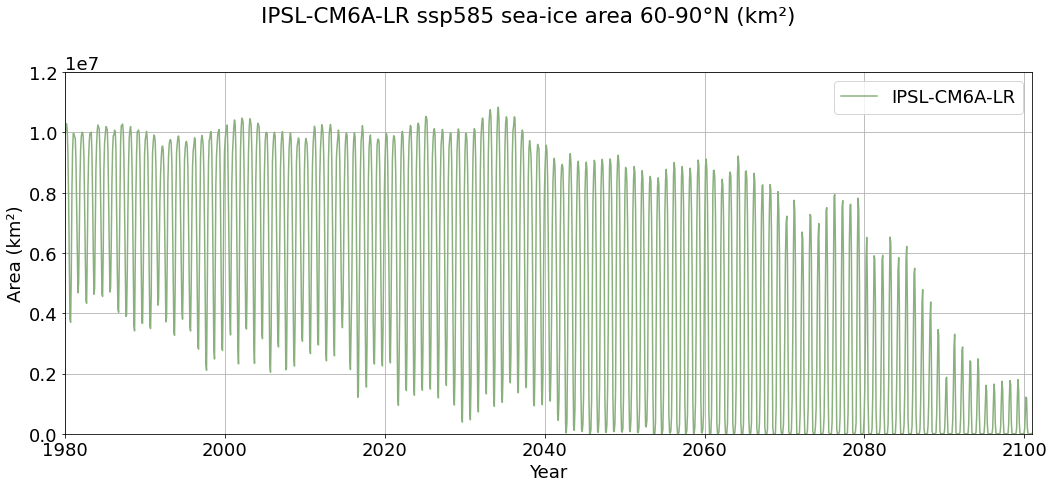

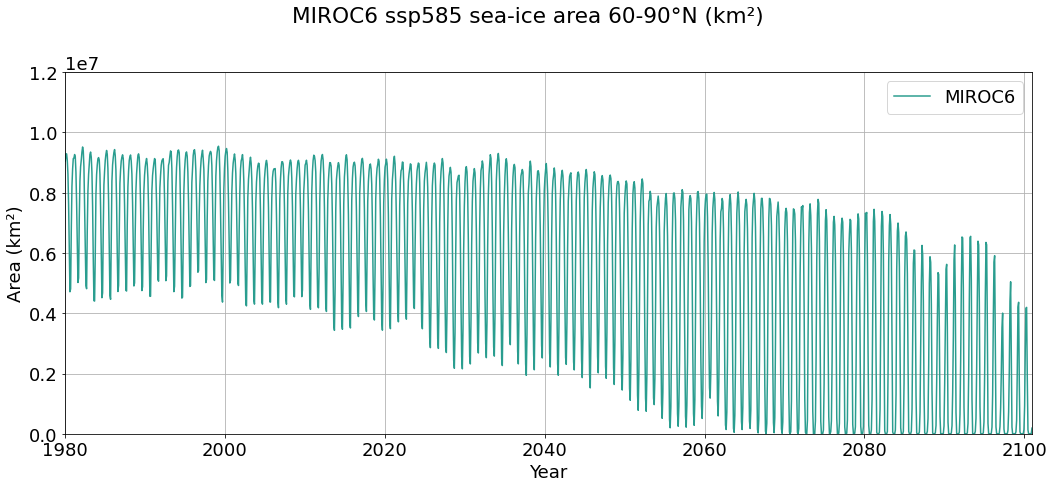

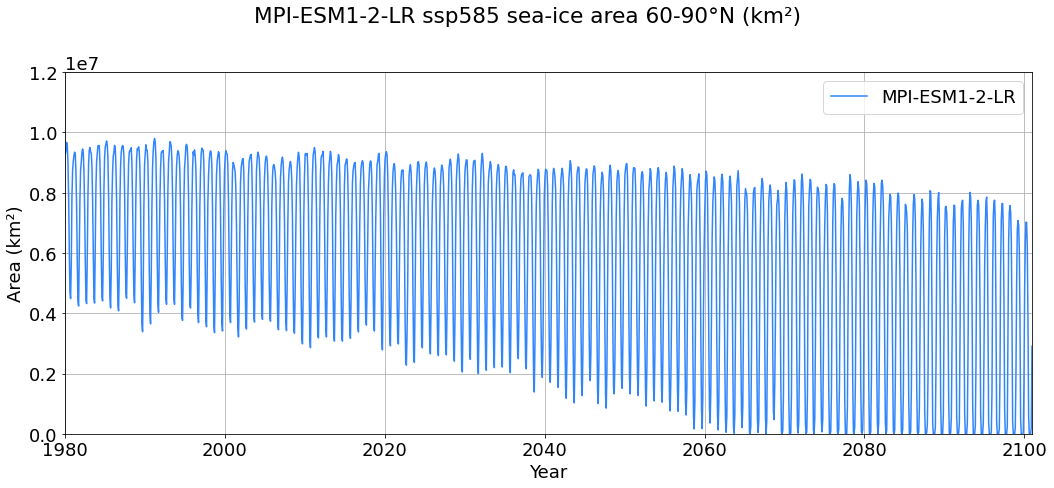

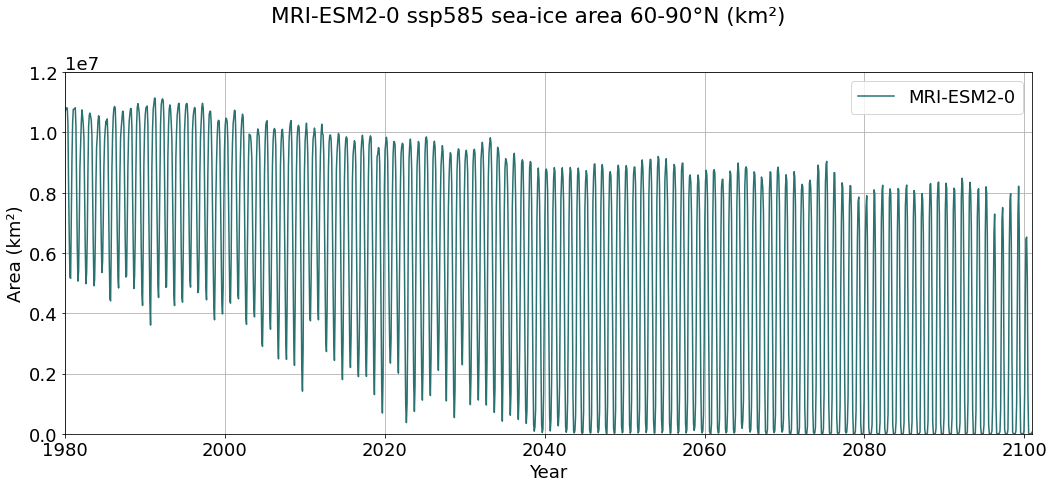

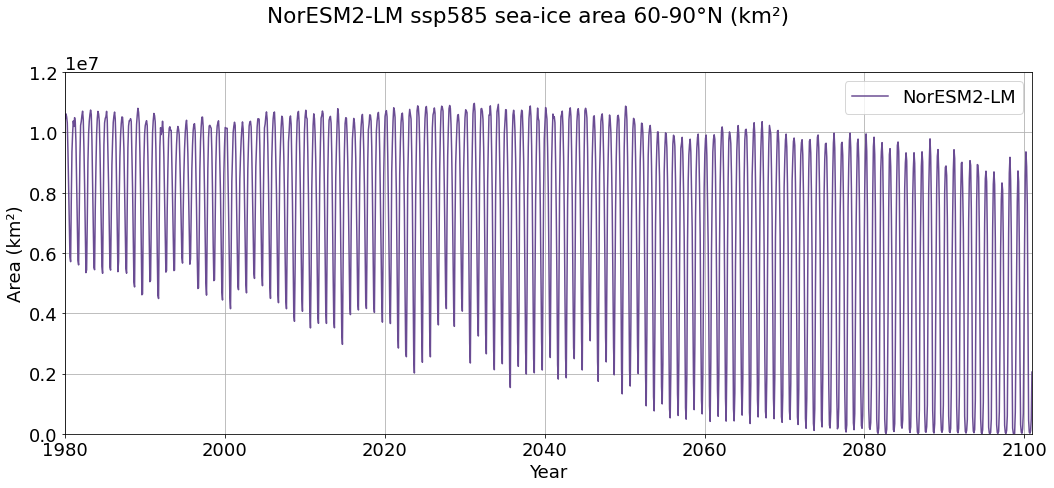

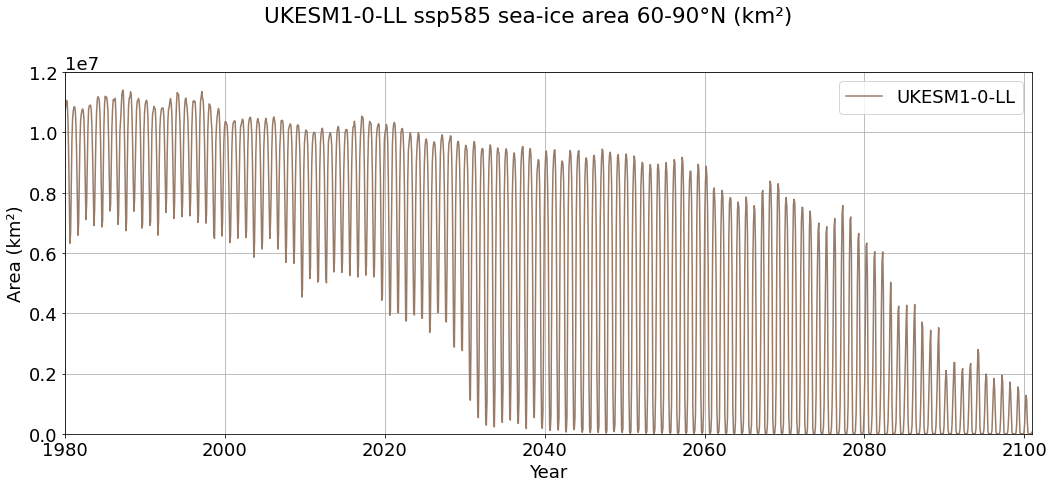

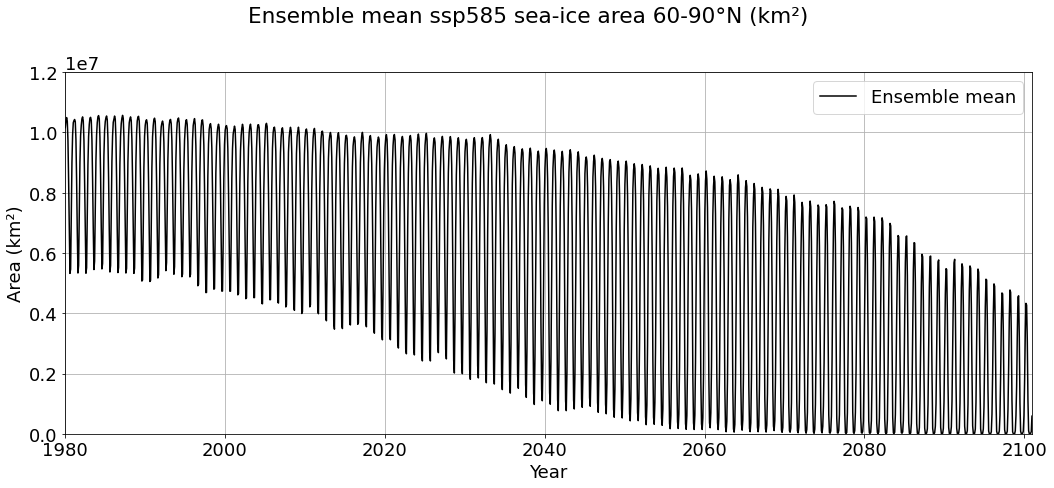

In [10]:
libs.ensemble.time_series_full_variability(
    ensemble_time_series,
    plot_kwargs={
        'title': f'{{member}} {experiment} {time_series_text} 60-90°N ({time_series_units})',
        'ylabel': time_series_y_label,
        'yrange': time_series_y_range_full
    }
)

## Monthly variability

### Full region (time)

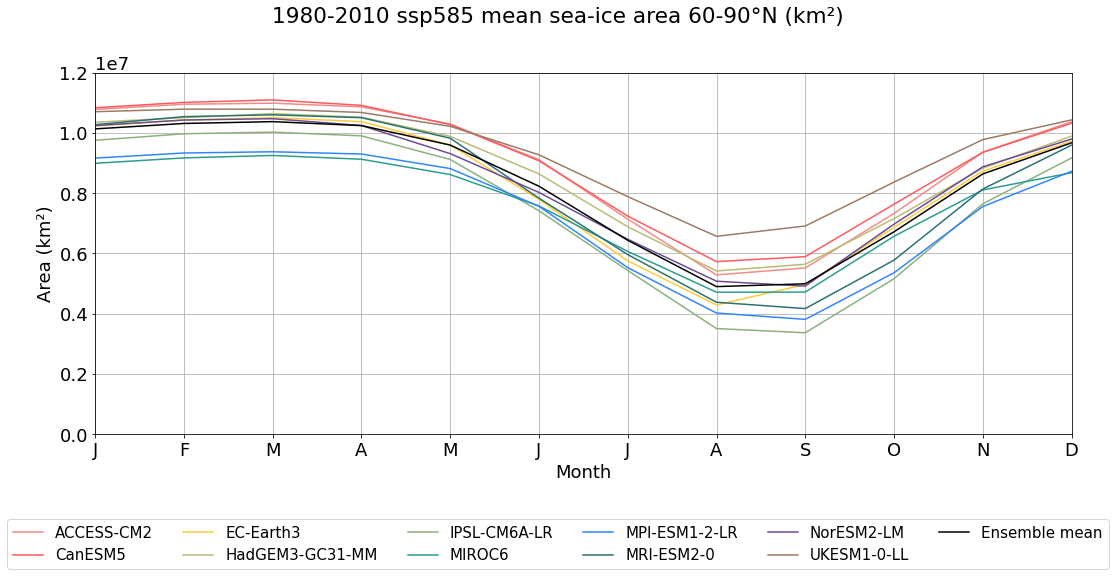

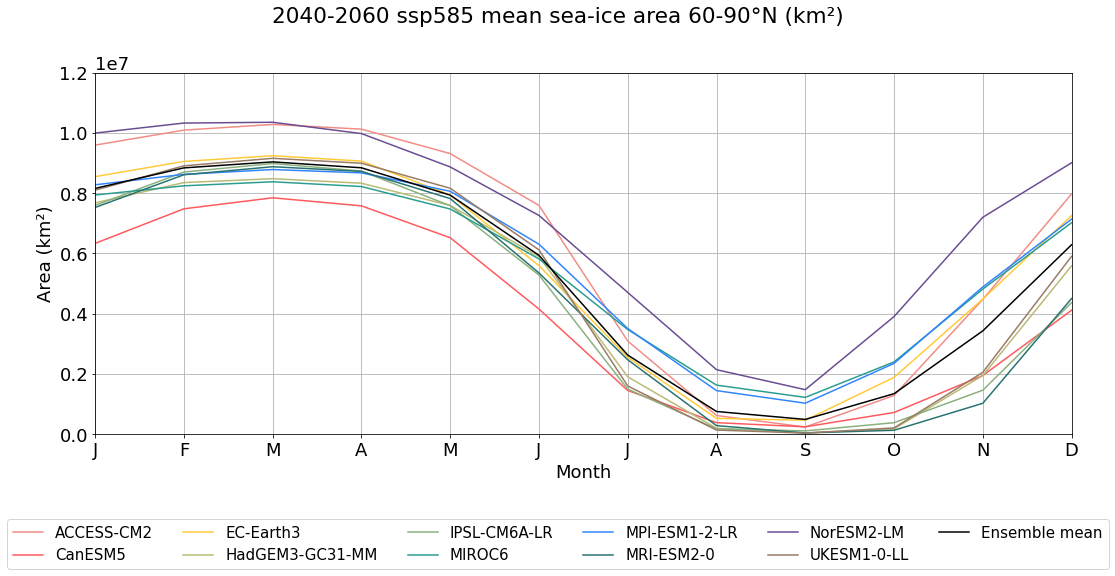

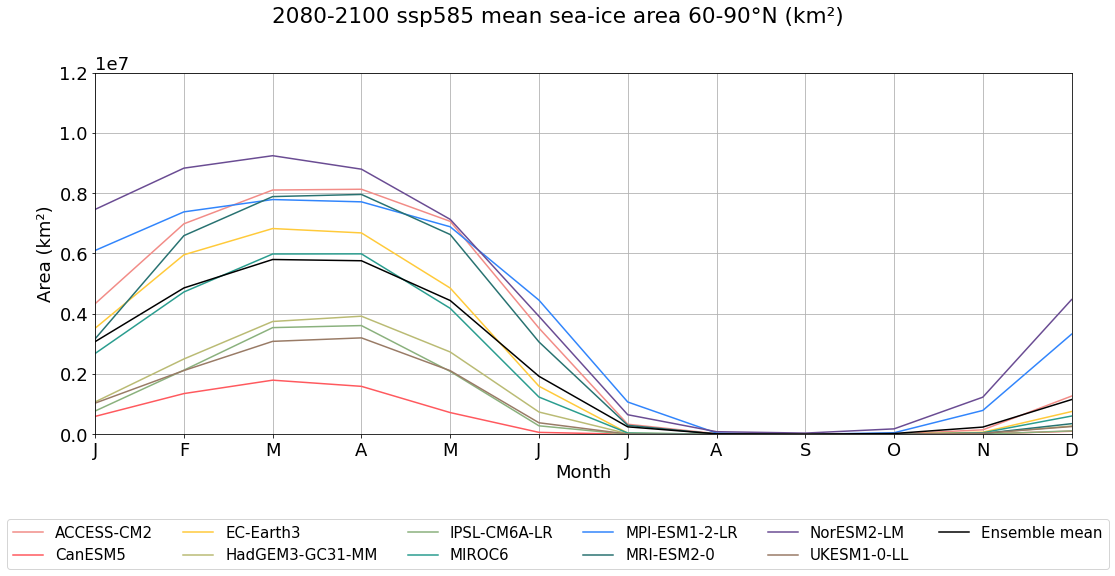

In [11]:
for s in time_slices:
    s_label = s['label']

    libs.plot.monthly_variability(
        ensemble_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_monthly
    )

### Regional sea-ice area (time)

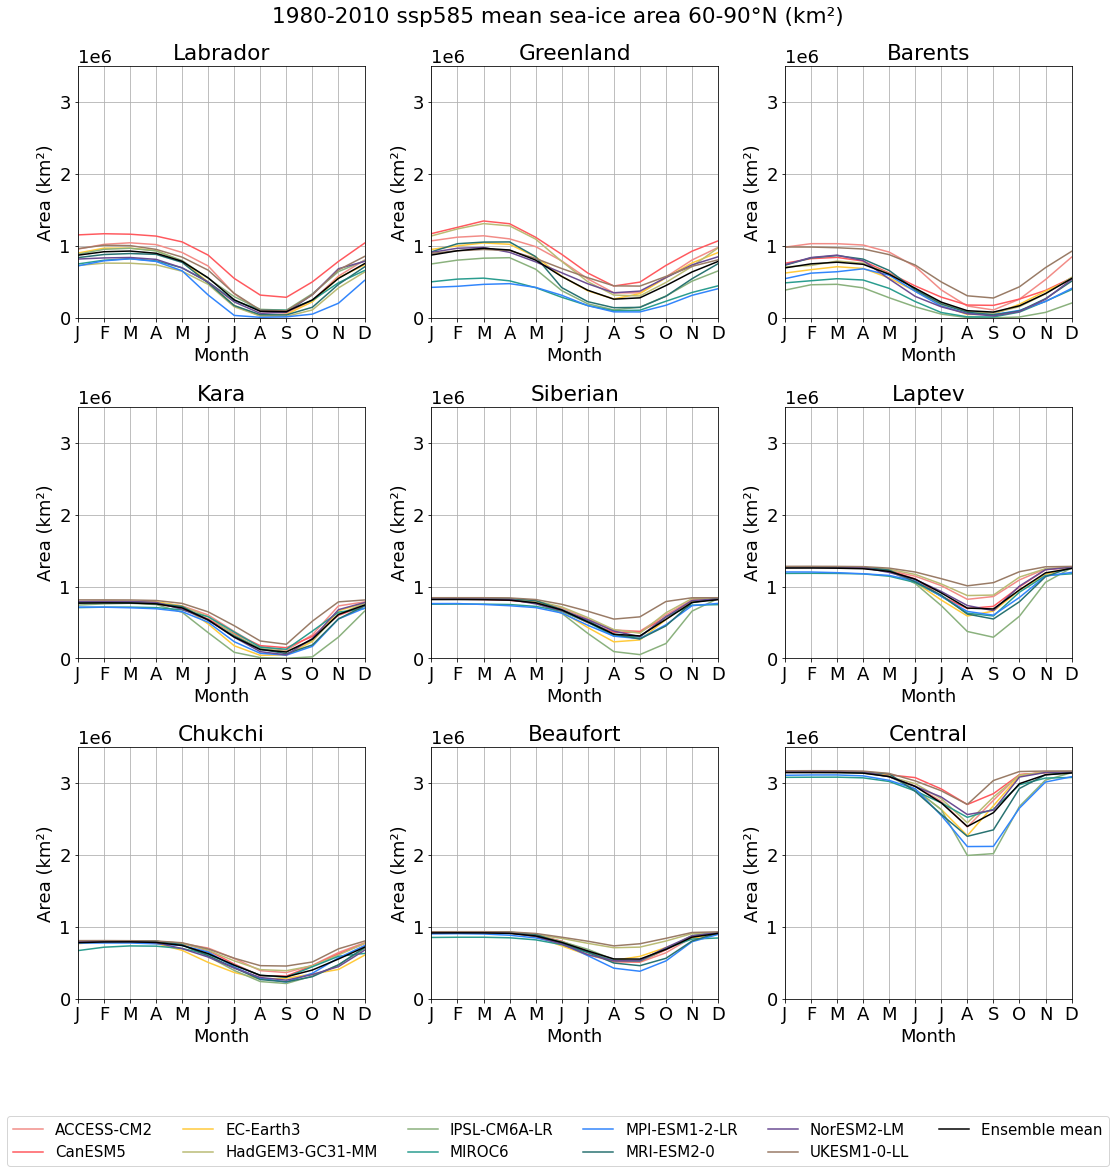

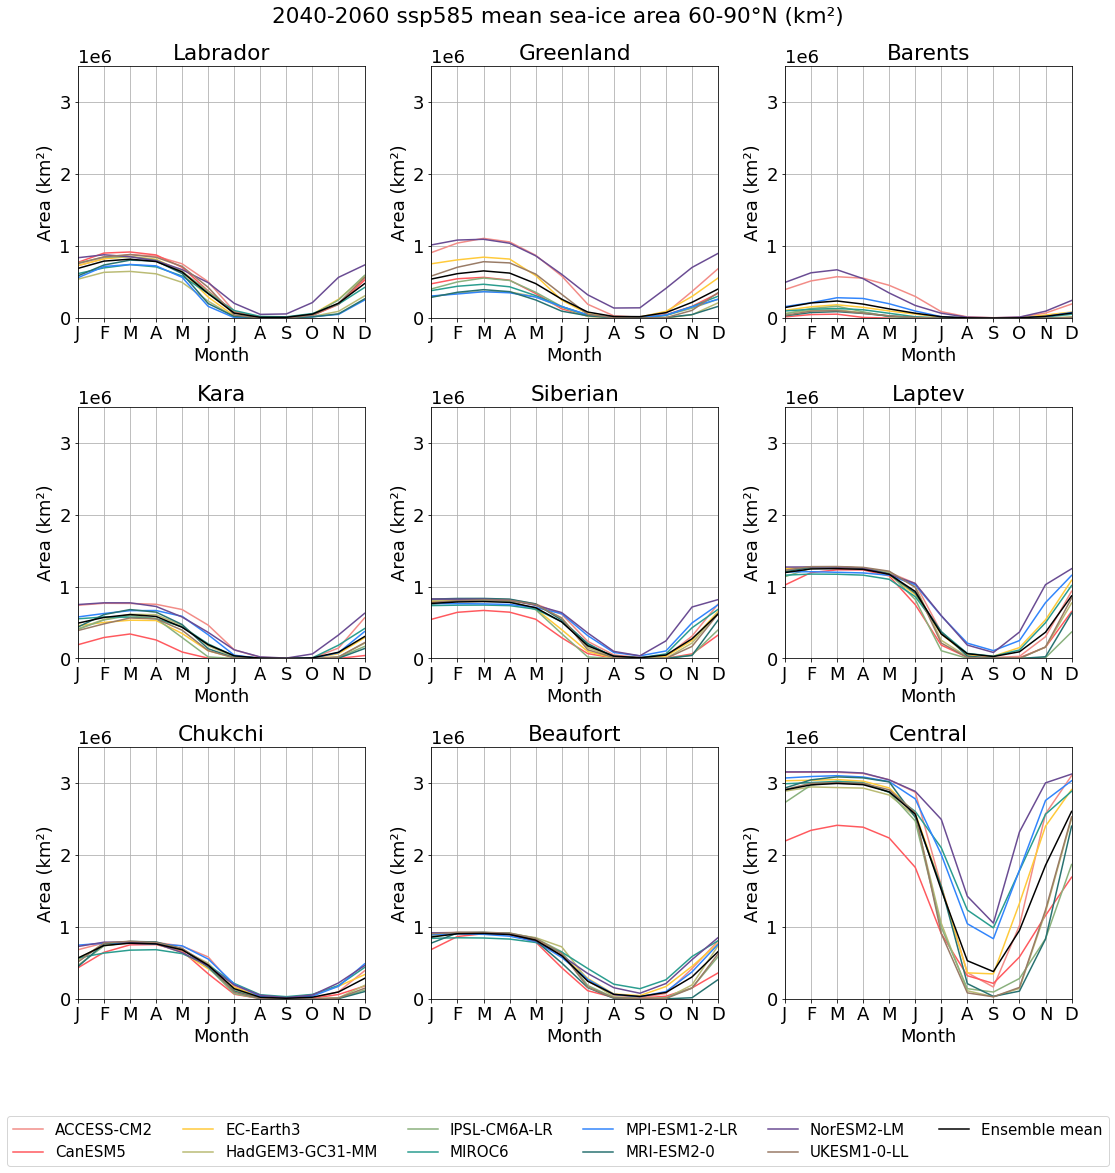

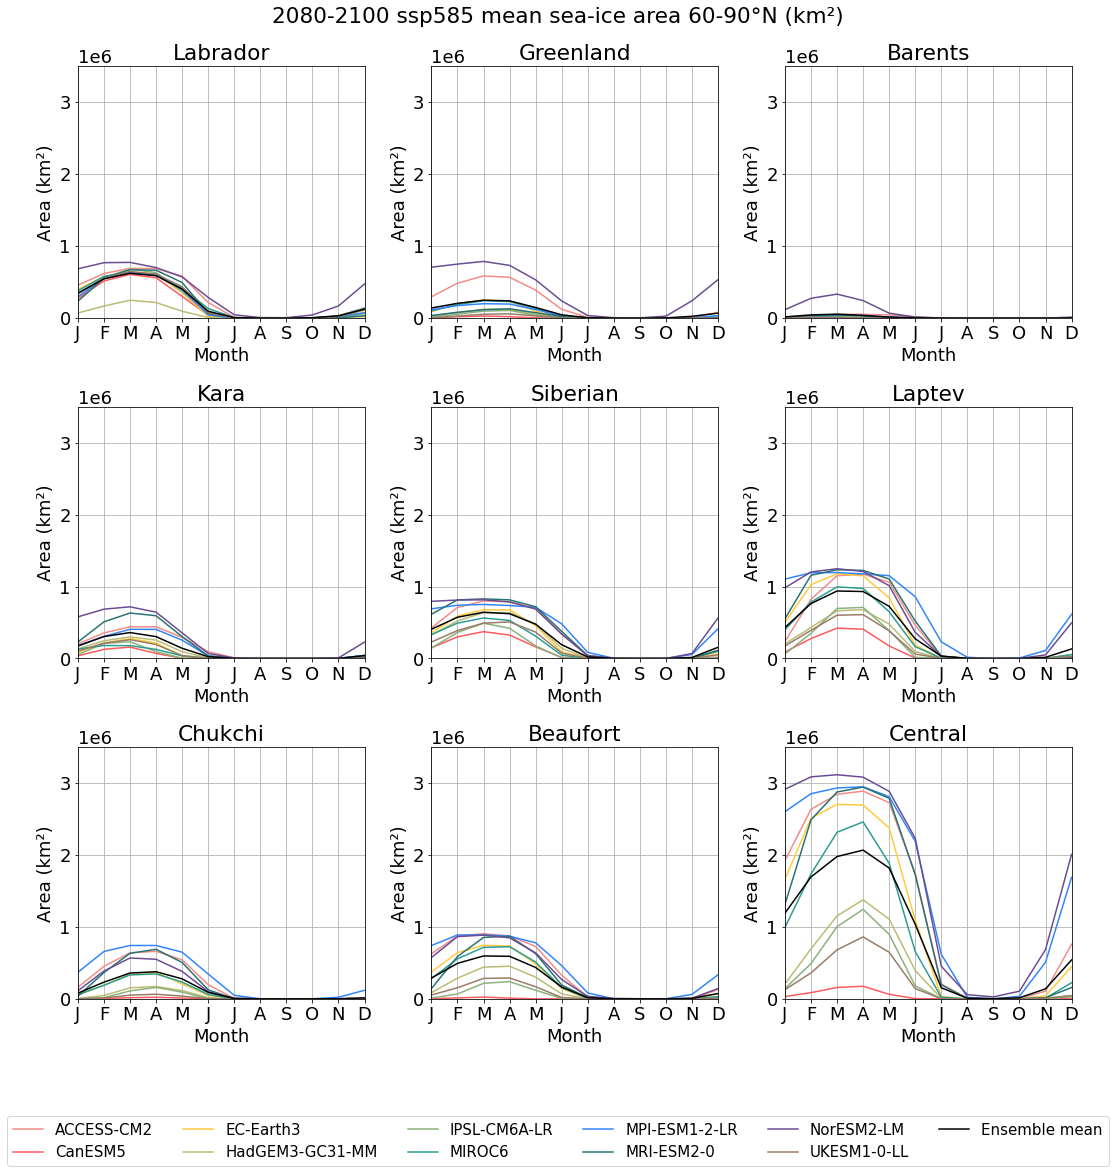

In [12]:
regions = libs.local.get_ensemble_regional_series(variable_id, experiment)

for s in time_slices:
    s_label = s['label']
    regional_time_slices = [
        data.sel(**s['slice']).groupby('time.month').mean('time') for data in regions
    ]

    libs.plot.monthly_variability_regional(
        regional_time_slices,
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_regional
    )

### Full region March maximum (spatial)

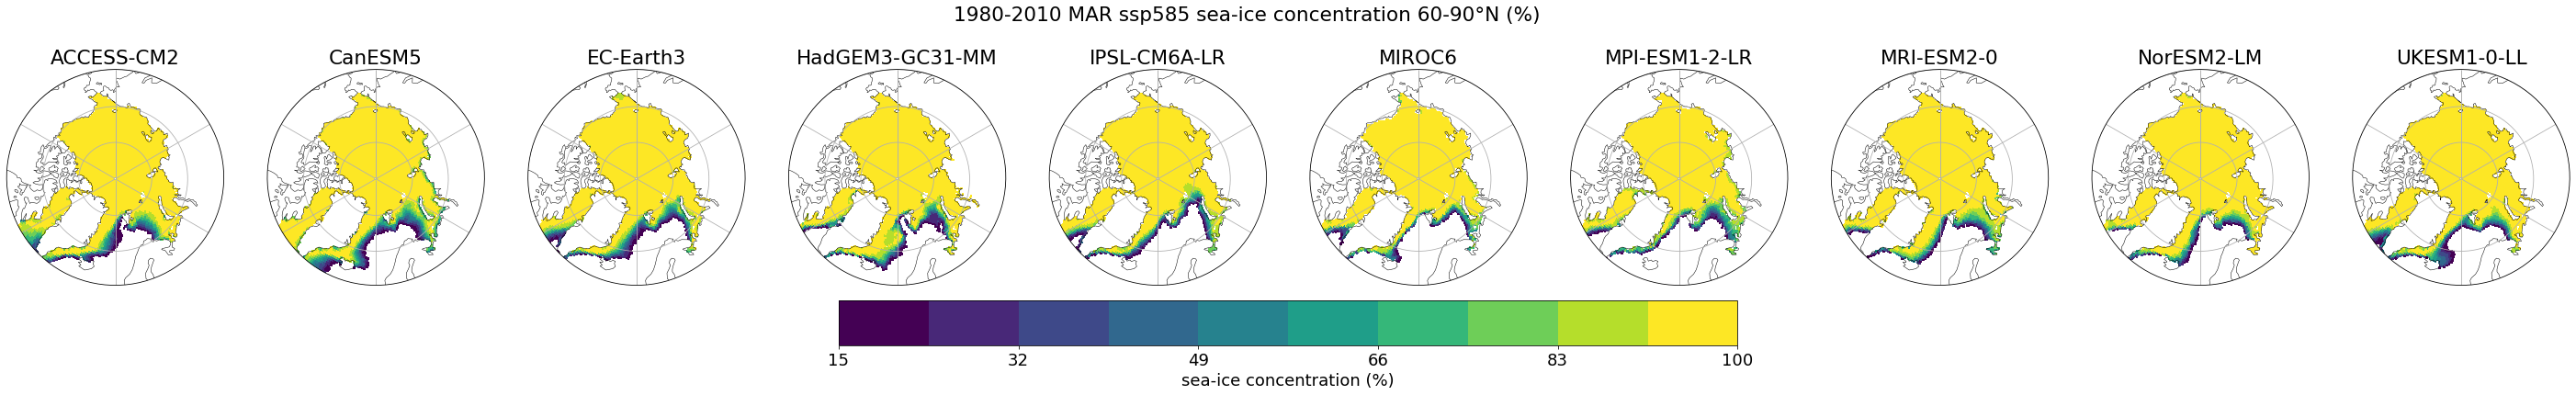

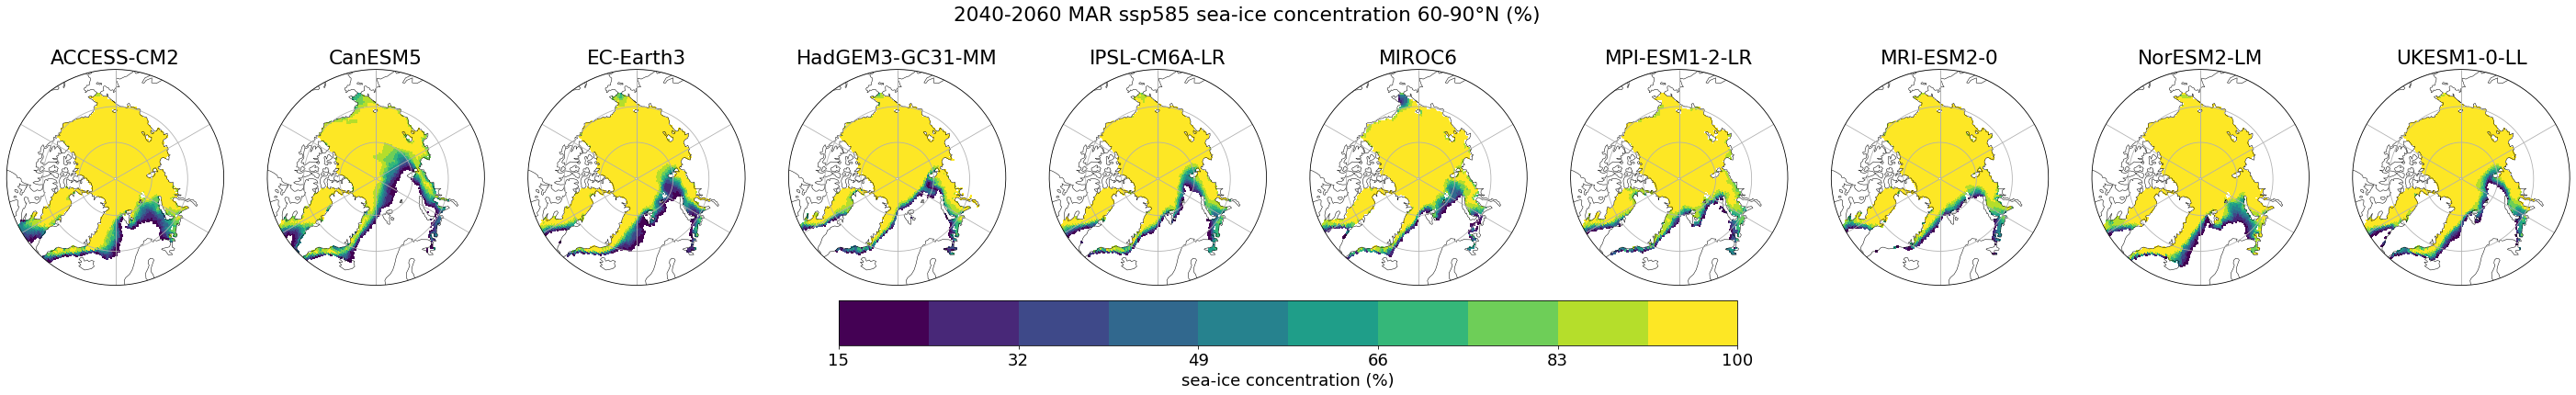

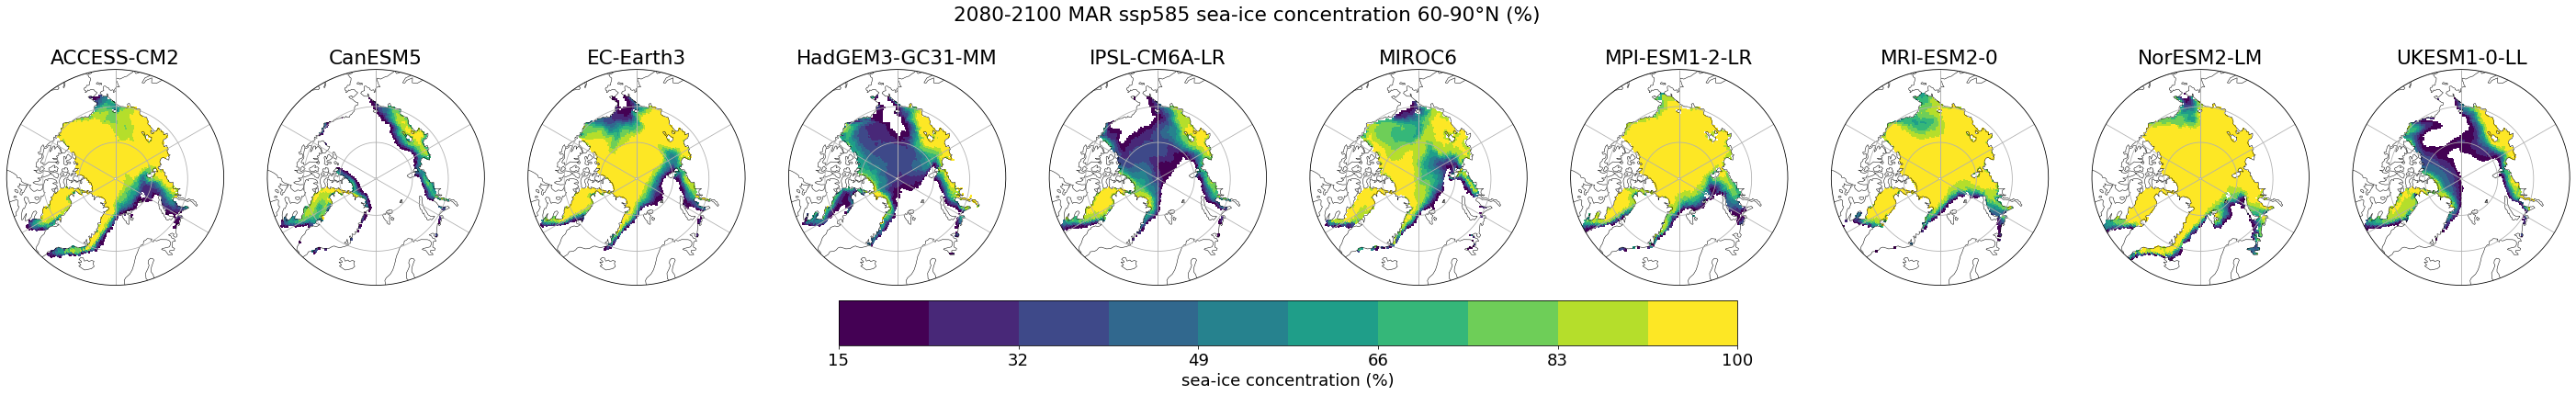

In [13]:
import warnings
warnings.filterwarnings('ignore')

libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='MAR',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)

### Full region September minimum (spatial)

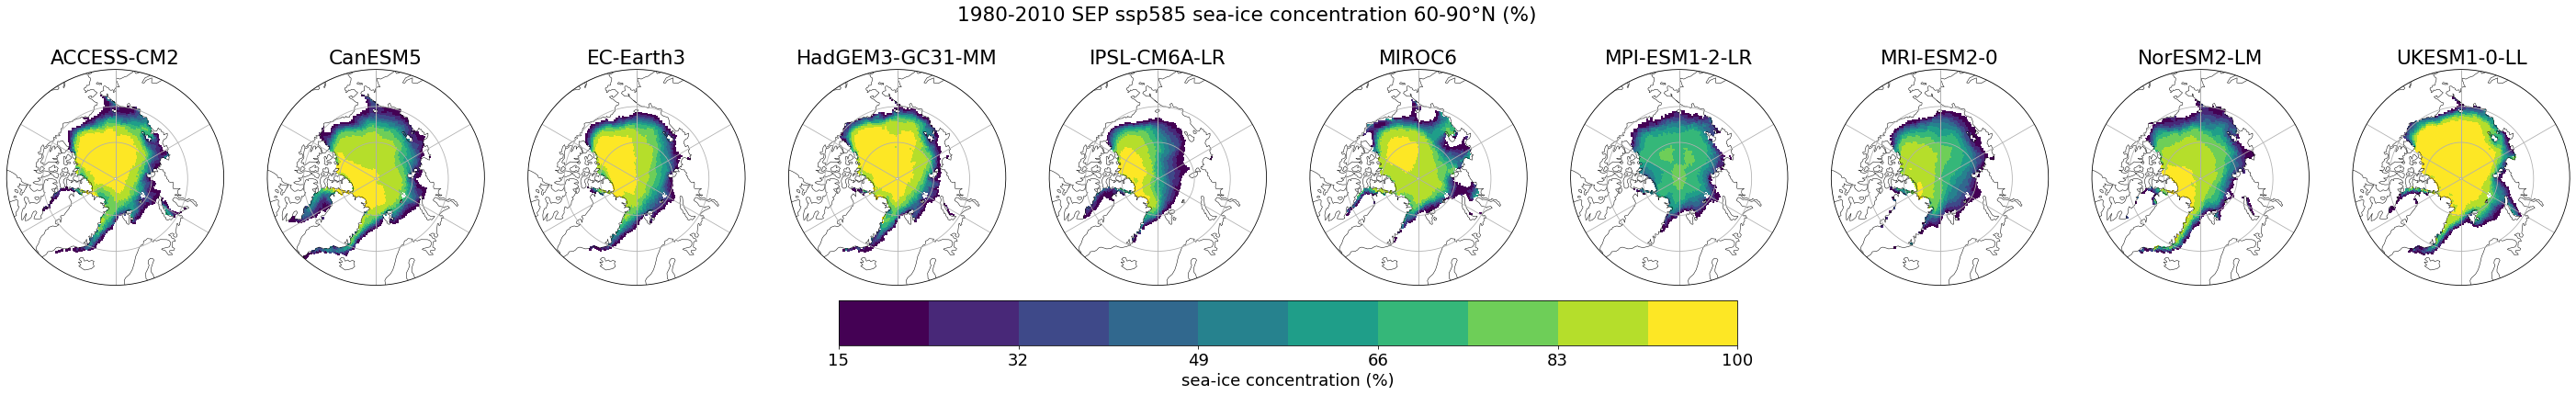

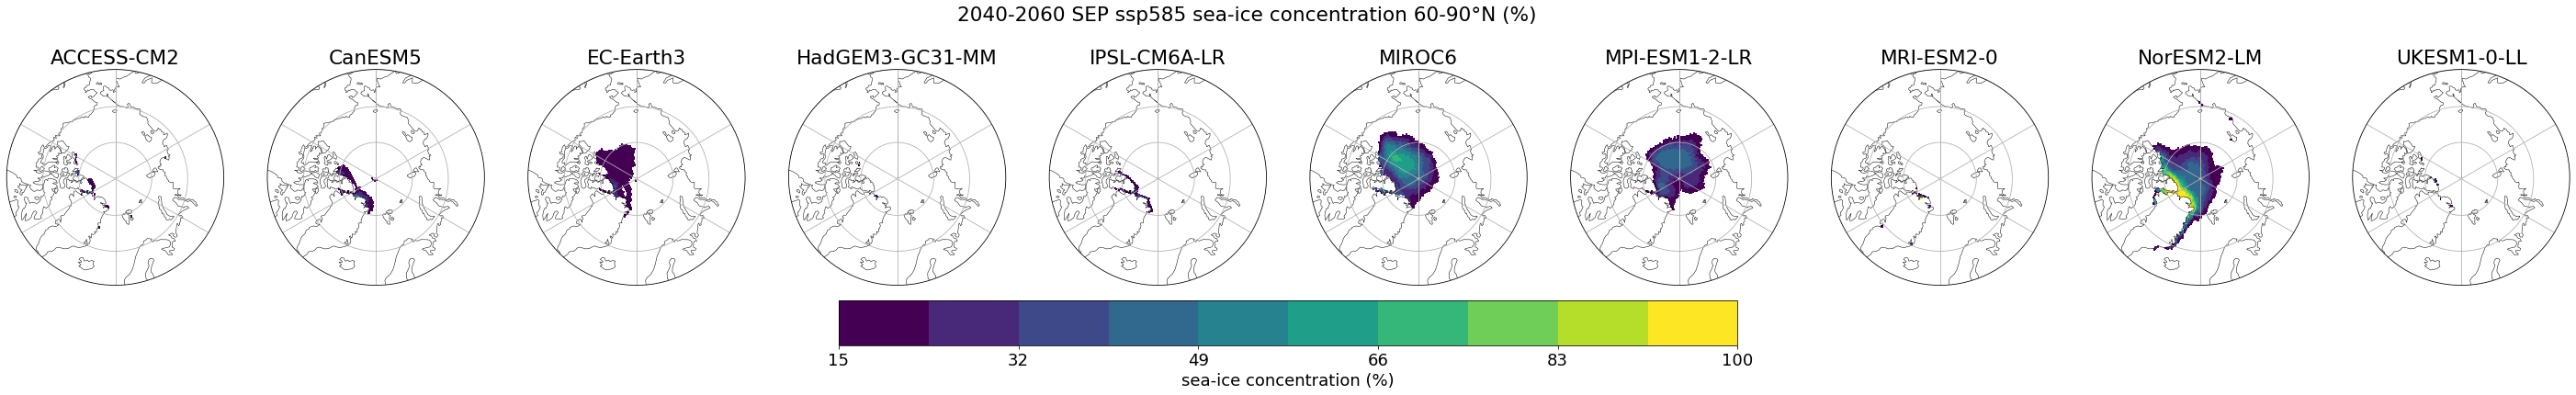

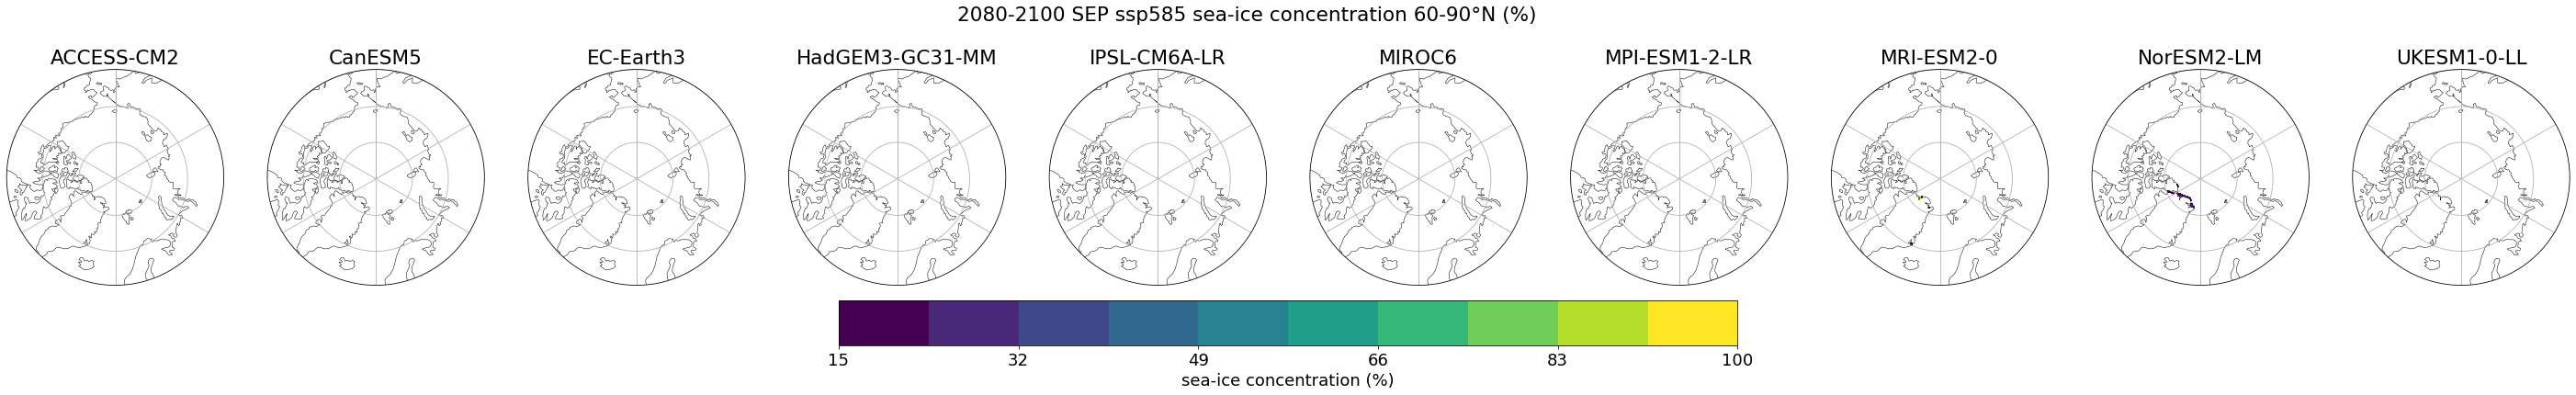

In [14]:
libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='SEP',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)